<a href="https://colab.research.google.com/github/jaredmarko/Poker-RL/blob/main/PokerRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
Episode 48370/50000, Total Reward: 36.6
Updated Opponent Performance: {'conservative': {'wins': 12193, 'losses': 4119}, 'aggressive': {'wins': 6269, 'losses': 9756}, 'balanced': {'wins': 9714, 'losses': 6320}}
Episode 48371/50000, Total Reward: 40
Updated Opponent Performance: {'conservative': {'wins': 12193, 'losses': 4119}, 'aggressive': {'wins': 6269, 'losses': 9756}, 'balanced': {'wins': 9714, 'losses': 6320}}
Updated Opponent Performance: {'conservative': {'wins': 12193, 'losses': 4119}, 'aggressive': {'wins': 6269, 'losses': 9756}, 'balanced': {'wins': 9714, 'losses': 6320}}
Updated Opponent Performance: {'conservative': {'wins': 12193, 'losses': 4119}, 'aggressive': {'wins': 6269, 'losses': 9756}, 'balanced': {'wins': 9715, 'losses': 6320}}
Episode 48372/50000, Total Reward: 38.5
Updated Opponent Performance: {'conservative': {'wins': 12194, 'losses': 4119}, 'aggressive': {'wins': 6269, 'losses': 9756}, 'balanced': {'wins': 9715

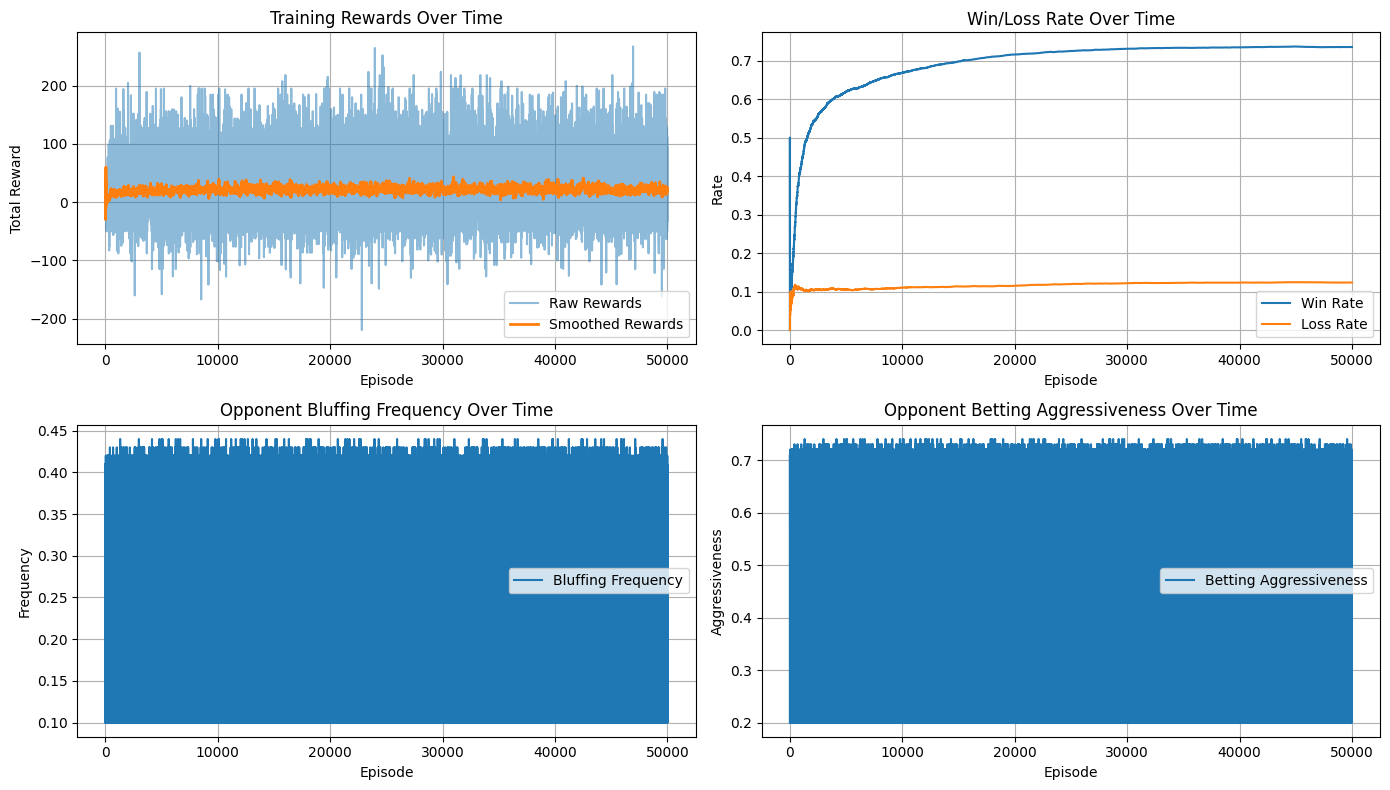

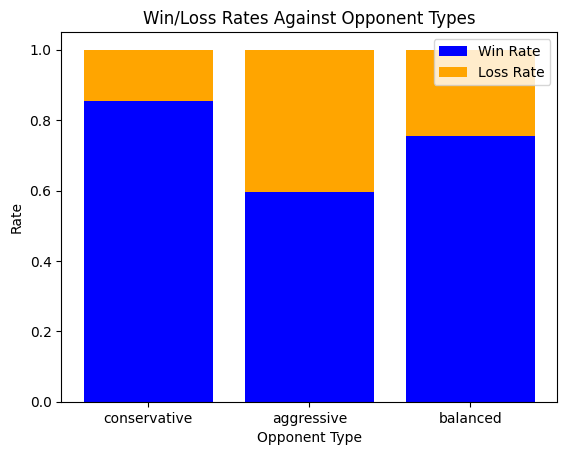

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Advanced Poker Environment
class PokerEnvironment:
    def __init__(self):
       self.opponent_profiles = {
            "conservative": {"bluffing_frequency": 0.1, "betting_aggressiveness": 0.2, "fold_rate": 0.6},
            "aggressive": {"bluffing_frequency": 0.4, "betting_aggressiveness": 0.7, "fold_rate": 0.2},
            "balanced": {"bluffing_frequency": 0.2, "betting_aggressiveness": 0.5, "fold_rate": 0.3},
        }
       self.current_opponent_profile = random.choice(["conservative", "aggressive", "balanced"])  # Initialize here
       self.current_opponent = self.opponent_profiles[self.current_opponent_profile]  # Match the profile
       self.opponent_stats = self.current_opponent.copy()
       self.opponent_performance = {
          "conservative": {"wins": 0, "losses": 0},
          "aggressive": {"wins": 0, "losses": 0},
          "balanced": {"wins": 0, "losses": 0},
      }
       self.log = []
       self.total_games = 0
       self.total_wins = 0
       self.total_losses = 0
       self.reset()

    def plot_performance(self):
        print("Updated Opponent Performance:", self.opponent_performance)


    def select_opponent(self):
        return random.choice(list(self.opponent_profiles.values()))

    def reset(self):
        """Reset the environment to start a new hand."""
        self.current_opponent_profile = random.choice(["conservative", "aggressive", "balanced"])  # Select opponent type
        self.current_opponent = self.opponent_profiles[self.current_opponent_profile]  # Match the profile
        self.opponent_stats = self.current_opponent.copy()
        self.log = []  # Clear the log for a new game
        self.deck = self.create_deck()
        random.shuffle(self.deck)
        self.community_cards = []
        self.pot = 0
        self.agent_private_cards = [self.deck.pop(), self.deck.pop()]
        self.opponent_private_cards = [self.deck.pop(), self.deck.pop()]
        self.betting_round = 0
        return self.get_state()

    def create_deck(self):
        """Create a standard deck of cards."""
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        return [(rank, suit) for rank in ranks for suit in suits]

    def deal_community_cards(self, count):
        """Add community cards to the board."""
        for _ in range(count):
            self.community_cards.append(self.deck.pop())

    def evaluate_hand(self, hand):
        """Evaluate the hand using poker rules."""
        # Extract ranks and suits
        rank_order = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8,
                      '9': 9, '10': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
        rank_counts = {}
        suit_counts = {}

        for rank, suit in hand:
            rank_counts[rank] = rank_counts.get(rank, 0) + 1
            suit_counts[suit] = suit_counts.get(suit, 0) + 1

        # Detect poker hands
        is_flush = max(suit_counts.values()) >= 5
        is_straight = self.is_straight(rank_counts.keys(), rank_order)

        if is_flush and is_straight:
            return 9  # Straight flush
        elif 4 in rank_counts.values():
            return 8  # Four of a kind
        elif 3 in rank_counts.values() and 2 in rank_counts.values():
            return 7  # Full house
        elif is_flush:
            return 6  # Flush
        elif is_straight:
            return 5  # Straight
        elif 3 in rank_counts.values():
            return 4  # Three of a kind
        elif list(rank_counts.values()).count(2) == 2:
            return 3  # Two pair
        elif 2 in rank_counts.values():
            return 2  # One pair
        else:
            return 1  # High card

    def is_straight(self, ranks, rank_order):
        """Helper function to detect straights."""
        rank_values = sorted([rank_order[rank] for rank in ranks])
        for i in range(len(rank_values) - 4):
            if rank_values[i:i+5] == list(range(rank_values[i], rank_values[i]+5)):
                return True
        return False

    def calculate_hand_strength(self, private_cards, community_cards):
        """Evaluate hand strength with special handling for pre-flop."""
        if not community_cards:  # Pre-flop
            # Check for pocket pairs
            if private_cards[0][0] == private_cards[1][0]:
                rank = private_cards[0][0]
                rank_order = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,
                              '8': 8, '9': 9, '10': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
                return rank_order[rank] + 20  # Pocket pairs get a boost
            else:
                # Assign strength based on highest card in private cards
                rank_order = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,
                              '8': 8, '9': 9, '10': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
                return max(rank_order[private_cards[0][0]], rank_order[private_cards[1][0]])
        else:
            # Post-flop: Use existing evaluation
            return self.evaluate_hand(private_cards + community_cards)

    def get_state(self):
        """Return the current state including opponent behavior stats."""
        agent_strength = self.calculate_hand_strength(self.agent_private_cards, self.community_cards)
        state = {
            'agent_strength': agent_strength,
            'opponent_bluffing_frequency': self.opponent_stats['bluffing_frequency'],
            'opponent_betting_aggressiveness': self.opponent_stats['betting_aggressiveness'],
            'opponent_fold_rate': self.opponent_stats['fold_rate'],
            'betting_round': self.betting_round,
        }
        return state

    def current_opponent_type(self):
      """Return the current opponent type as a string."""
      return self.current_opponent_profile  # Use the correct attribute

    def step(self, action):
      """Perform the chosen action and update the environment."""
      reward = 0
      done = False

      self.current_opponent_profile = random.choice(["conservative", "aggressive", "balanced"])

      if self.betting_round == 1:
          self.deal_community_cards(3)  # Deal flop
      elif self.betting_round == 2:
          self.deal_community_cards(1)  # Deal turn
      elif self.betting_round == 3:
          self.deal_community_cards(1)  # Deal river

      agent_strength = self.calculate_hand_strength(self.agent_private_cards, self.community_cards)
      opponent_strength = self.calculate_hand_strength(self.opponent_private_cards, self.community_cards)

      strength_diff = agent_strength - opponent_strength
      is_late_round = self.betting_round >= 2  # Final rounds

      # Dynamic Bluff Adjustments
      opponent_recent_behavior = (self.opponent_stats['bluffing_frequency'] +
                                  self.opponent_stats['betting_aggressiveness']) / 2
      is_bluff_likely = opponent_recent_behavior > 0.6  # Threshold for bluff likelihood


      # Adaptive reward for actions
      if action == 'fold':
          reward = -0.1 * self.pot  # Slight penalty to discourage excessive folding
          done = True
      elif action == 'call':
          self.pot += 10
          if strength_diff < -1:  # Opponent likely stronger
              reward = -15 if is_late_round else -5
          elif strength_diff > 1:  # Agent likely stronger
              reward = 30 if is_late_round else 20
          else:
              reward = 10 if is_bluff_likely else 5

          if is_late_round and opponent_recent_behavior < 0.4:  # Less aggressive opponent
            reward += 5  # Encourage calculated risks

          # Exploit opponent bluffing
          if self.opponent_stats['bluffing_frequency'] > 0.3:  # High bluffing tendency
              reward += 10 if strength_diff >= 0 else -5

          if random.random() < self.opponent_stats['fold_rate']:
              reward += self.pot
              done = True
          elif self.betting_round == 3:
              reward += self.pot if agent_strength > opponent_strength else -self.pot
              done = True
      elif action == 'raise':
          self.pot += 20
          if strength_diff < -2:  # Opponent very likely stronger
              reward = -50 if is_late_round else -30
          elif strength_diff > 2:  # Agent significantly stronger
              reward = 60 if is_late_round else 40
          else:
              reward = 10 if is_bluff_likely else -10

          # Final-round adjustments for raises
          if is_late_round and is_bluff_likely:
              reward *= 0.8  # Penalize reckless raises in final round

          if random.random() < self.opponent_stats["bluffing_frequency"]:
            reward += self.pot if agent_strength > opponent_strength else -self.pot
            done = True

      # Adjust rewards based on betting round context
      if self.betting_round == 1:  # Early round adjustments
          reward *= 0.7
      elif self.betting_round == 3:  # Late round adjustments
          reward *= 1.3

      # Opponent behavior updates
      if reward < 0:  # Agent loses
          self.opponent_stats['bluffing_frequency'] = min(1.0, self.opponent_stats['bluffing_frequency'] + 0.01)
          self.opponent_stats['betting_aggressiveness'] = min(1.0, self.opponent_stats['betting_aggressiveness'] + 0.01)
      else:  # Agent wins
          self.opponent_stats['fold_rate'] = max(0.0, self.opponent_stats['fold_rate'] + 0.01)

      # Advance round
      self.betting_round += 1
      if self.betting_round > 3:
          done = True

      if done:
          profile_name = None
          for k, v in self.opponent_profiles.items():
              if v == self.current_opponent:  # Match the current opponent
                  profile_name = k
                  break

          if profile_name:
              if reward > 0:  # Agent wins
                  self.opponent_performance[profile_name]["wins"] += 1
              else:  # Opponent wins
                  self.opponent_performance[profile_name]["losses"] += 1

      print("Updated Opponent Performance:", self.opponent_performance)
      # Log the action
      self.log.append({
          'action': action,
          'agent_private_cards': self.agent_private_cards,
          'opponent_private_cards': self.opponent_private_cards,
          'community_cards': self.community_cards,
          'reward': reward,
          'betting_round': self.betting_round,
          'agent_strength': agent_strength,
          'opponent_strength': opponent_strength,
          'strength_diff': strength_diff,
          'is_optimal_call': action == 'call' and strength_diff > 1,
          'is_optimal_raise': action == 'raise' and agent_strength >= 6,
          'is_risky_raise': action == 'raise' and agent_strength < 3,
      })

      return self.get_state(), reward, done



# Advanced Q-Learning Agent
class PokerQLearningAgent:
    def __init__(self, environment, alpha=0.05, gamma=0.9, epsilon=0.2):
        self.env = environment
        self.q_table = defaultdict(float)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = max(0.01, epsilon * 0.99)
        self.opponent_memory = []
        self.win_count = 0  # New metric to track wins
        self.loss_count = 0  # New metric to track losses

    def get_q_value(self, state, action):
        return self.q_table[(str(state), action)]

    def update_q_value(self, state, action, reward, next_state):
        old_value = self.get_q_value(state, action)
        next_max = max([self.get_q_value(next_state, a) for a in ['fold', 'call', 'raise']])
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table[(str(state), action)] = new_value

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(['fold', 'call', 'raise'])
        q_values = {a: self.get_q_value(state, a) for a in ['fold', 'call', 'raise']}
        return max(q_values, key=q_values.get)

    def train(self, episodes=200):
        rewards = []
        hand_logs = []
        win_rate = []  # Track win rate over episodes
        loss_rate = []  # Track loss rate over episodes
        opponent_stats_over_time = []  # Track opponent behavior over episodes
        episode_opponent_types = []

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False

            # Log the opponent type at the start of the episode
            opponent_type = self.env.current_opponent_type()
            episode_opponent_types.append(opponent_type)  # New: Append opponent type

            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)
                total_reward += reward
                state = next_state

            # Update metrics
            if total_reward > 0:
                self.win_count += 1
            elif total_reward < 0:
                self.loss_count += 1

            win_rate.append(self.win_count / (episode + 1))
            loss_rate.append(self.loss_count / (episode + 1))
            opponent_stats_over_time.append(self.env.opponent_stats.copy())

            rewards.append(total_reward)
            hand_logs.append(self.env.log)
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        return rewards, win_rate, loss_rate, opponent_stats_over_time, hand_logs, episode_opponent_types

def smooth_rewards(rewards, window_size=50):
        """Compute the moving average of the rewards."""
        cumsum = np.cumsum(np.insert(rewards, 0, 0))
        smoothed = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
        return np.concatenate((rewards[:window_size-1], smoothed))

# Training and Evaluation
environment = PokerEnvironment()
agent = PokerQLearningAgent(environment)

# Train the agent
raw_rewards, win_rate, loss_rate, opponent_stats_over_time, hand_logs, episode_opponent_types = agent.train(episodes=50000)

opponent_specific_performance = {
    "conservative": {"wins": 0, "losses": 0},
    "aggressive": {"wins": 0, "losses": 0},
    "balanced": {"wins": 0, "losses": 0},
}

for i, opponent_type in enumerate(episode_opponent_types):
    if raw_rewards[i] > 0:  # Win
        opponent_specific_performance[opponent_type]["wins"] += 1
    else:  # Loss
        opponent_specific_performance[opponent_type]["losses"] += 1

smoothed_rewards = smooth_rewards(raw_rewards, window_size=50)

# Extract opponent behavior trends
bluffing_frequency = [stats['bluffing_frequency'] for stats in opponent_stats_over_time]
betting_aggressiveness = [stats['betting_aggressiveness'] for stats in opponent_stats_over_time]
fold_rate = [stats['fold_rate'] for stats in opponent_stats_over_time]

# Plot metrics
plt.figure(figsize=(14, 8))

# Plot rewards
plt.subplot(2, 2, 1)
plt.plot(raw_rewards, label="Raw Rewards", alpha=0.5)
plt.plot(smoothed_rewards, label="Smoothed Rewards", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards Over Time")
plt.legend()
plt.grid()

# Plot win/loss rates
plt.subplot(2, 2, 2)
plt.plot(win_rate, label="Win Rate")
plt.plot(loss_rate, label="Loss Rate")
plt.xlabel("Episode")
plt.ylabel("Rate")
plt.title("Win/Loss Rate Over Time")
plt.legend()
plt.grid()

# Plot opponent bluffing frequency
plt.subplot(2, 2, 3)
plt.plot(bluffing_frequency, label="Bluffing Frequency")
plt.xlabel("Episode")
plt.ylabel("Frequency")
plt.title("Opponent Bluffing Frequency Over Time")
plt.legend()
plt.grid()

# Plot opponent betting aggressiveness
plt.subplot(2, 2, 4)
plt.plot(betting_aggressiveness, label="Betting Aggressiveness")
plt.xlabel("Episode")
plt.ylabel("Aggressiveness")
plt.title("Opponent Betting Aggressiveness Over Time")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

opponent_types = list(opponent_specific_performance.keys())

# Calculate total games for each opponent type
total_games = [
    opponent_specific_performance[opponent]["wins"] + opponent_specific_performance[opponent]["losses"]
    for opponent in opponent_types
]

# Calculate win/loss rates
win_rates = [
    opponent_specific_performance[opponent]["wins"] / total_games[i] if total_games[i] > 0 else 0
    for i, opponent in enumerate(opponent_types)
]
loss_rates = [
    opponent_specific_performance[opponent]["losses"] / total_games[i] if total_games[i] > 0 else 0
    for i, opponent in enumerate(opponent_types)
]

# Plot win/loss rates as stacked bars
plt.bar(opponent_types, win_rates, label="Win Rate", color="blue")
plt.bar(opponent_types, loss_rates, bottom=win_rates, label="Loss Rate", color="orange")
plt.xlabel("Opponent Type")
plt.ylabel("Rate")
plt.title("Win/Loss Rates Against Opponent Types")
plt.legend()
plt.show()

In [ ]:
# Function to extract interesting hands
def find_interesting_hands(hand_log, condition, num_hands=5):
    """Filter hands based on a specific condition."""
    interesting_hands = []
    for episode_log in hand_log:
        for hand in episode_log:
            if condition(hand):  # Check if the hand matches the condition
                interesting_hands.append(hand)
    return interesting_hands[:num_hands]  # Return up to 'num_hands' interesting hands

# Define conditions for interesting hands
def big_win_condition(hand):
    return hand['reward'] > 50  # Big wins with rewards greater than 50

def successful_bluff_condition(hand):
    return hand['is_risky_raise'] and hand['reward'] > 0 and hand['strength_diff'] < 1  # Successful bluff

def close_call_condition(hand):
    return hand['agent_strength'] < hand['opponent_strength'] and hand['reward'] > 0  # Winning despite weaker cards

def risky_raise_condition(hand):
    return hand['is_risky_raise']  # All risky raises

# Extract interesting hands
big_wins = find_interesting_hands(hand_logs, big_win_condition)
successful_bluffs = find_interesting_hands(hand_logs, successful_bluff_condition)
close_calls = find_interesting_hands(hand_logs, close_call_condition)
risky_raises = find_interesting_hands(hand_logs, risky_raise_condition)

# Display interesting hands
from pprint import pprint

print("Big Wins:")
pprint(big_wins)

print("\nSuccessful Bluffs:")
pprint(successful_bluffs)

print("\nClose Calls:")
pprint(close_calls)

print("\nRisky Raises:")
pprint(risky_raises)

Big Wins:
[{'action': 'call',
  'agent_private_cards': [('10', 'spades'), ('5', 'spades')],
  'agent_strength': 2,
  'betting_round': 3,
  'community_cards': [('K', 'hearts'),
                      ('4', 'clubs'),
                      ('10', 'diamonds'),
                      ('3', 'spades')],
  'is_optimal_call': False,
  'is_optimal_raise': False,
  'is_risky_raise': False,
  'opponent_private_cards': [('5', 'diamonds'), ('K', 'diamonds')],
  'opponent_strength': 2,
  'reward': 60,
  'strength_diff': 0},
 {'action': 'raise',
  'agent_private_cards': [('9', 'spades'), ('9', 'clubs')],
  'agent_strength': 29,
  'betting_round': 1,
  'community_cards': [],
  'is_optimal_call': False,
  'is_optimal_raise': True,
  'is_risky_raise': False,
  'opponent_private_cards': [('3', 'diamonds'), ('7', 'diamonds')],
  'opponent_strength': 7,
  'reward': 60,
  'strength_diff': 22},
 {'action': 'call',
  'agent_private_cards': [('K', 'spades'), ('3', 'hearts')],
  'agent_strength': 2,
  'betting_rou

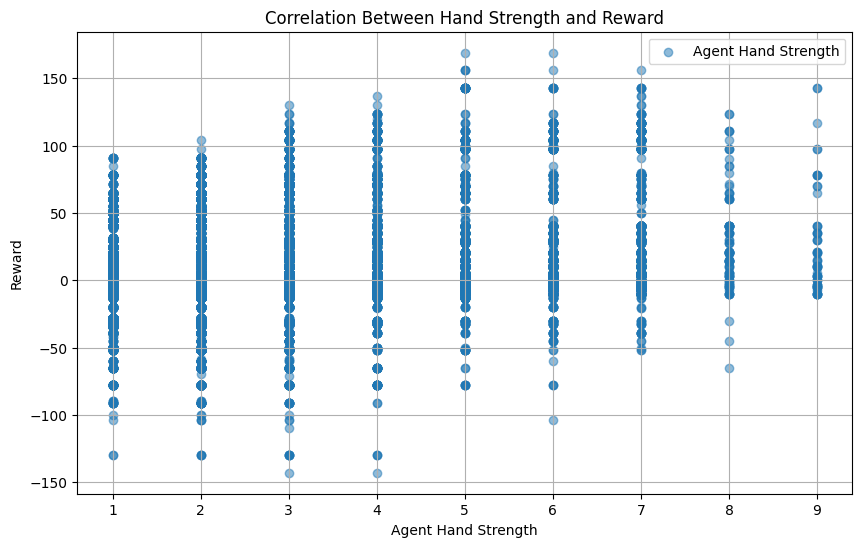

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for analysis
hand_data = []
for log in hand_logs:
    for entry in log:
        hand_data.append({
            'agent_hand_strength': environment.evaluate_hand(entry['agent_private_cards'] + entry['community_cards']),
            'opponent_hand_strength': environment.evaluate_hand(entry['opponent_private_cards'] + entry['community_cards']),
            'reward': entry['reward']
        })

# Create a DataFrame
df = pd.DataFrame(hand_data)

# Scatter plot: Hand Strength vs. Reward
plt.figure(figsize=(10, 6))
plt.scatter(df['agent_hand_strength'], df['reward'], alpha=0.5, label="Agent Hand Strength")
plt.xlabel('Agent Hand Strength')
plt.ylabel('Reward')
plt.title('Correlation Between Hand Strength and Reward')
plt.legend()
plt.grid()
plt.show()

<ipython-input-9-94a1f740c320>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exploitation_summary = df.groupby('opponent_bluffing_level')['reward'].mean().reset_index(name='Average Reward')


ModuleNotFoundError: No module named 'ace_tools'

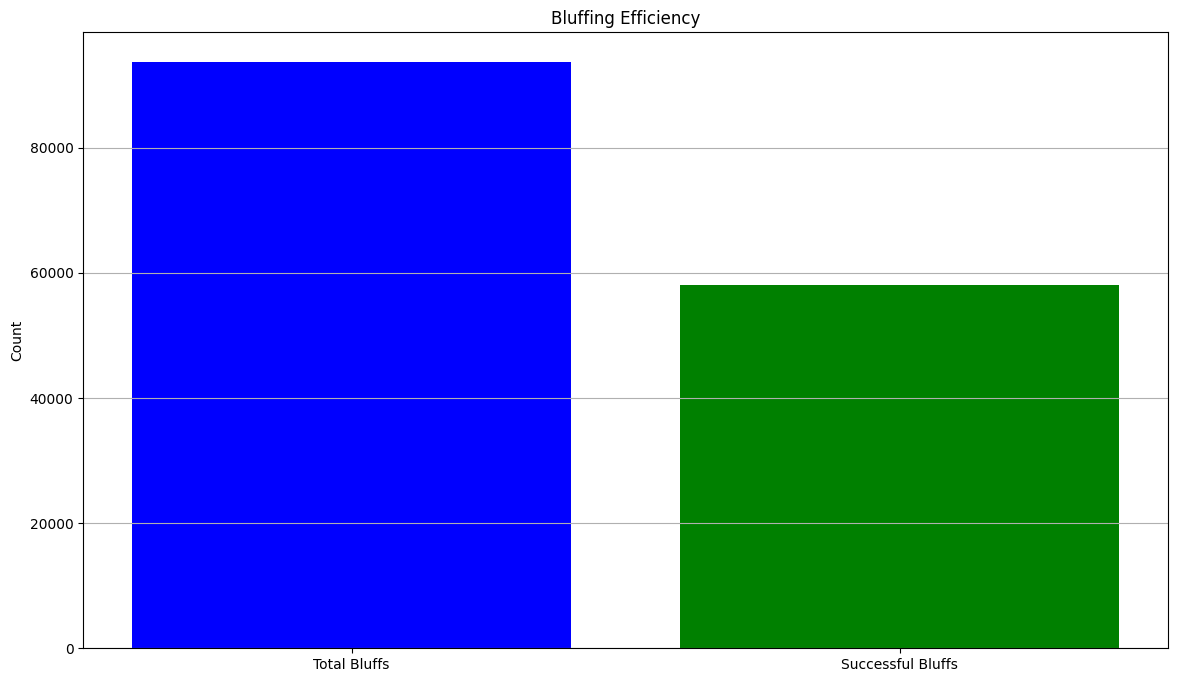

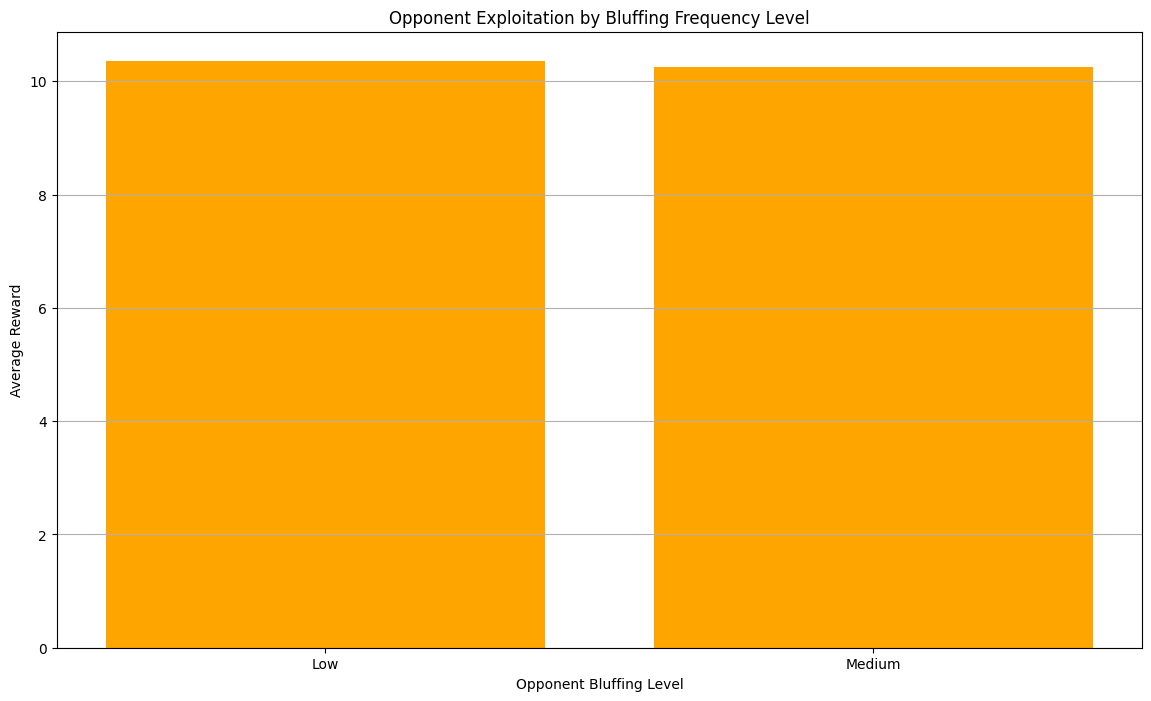

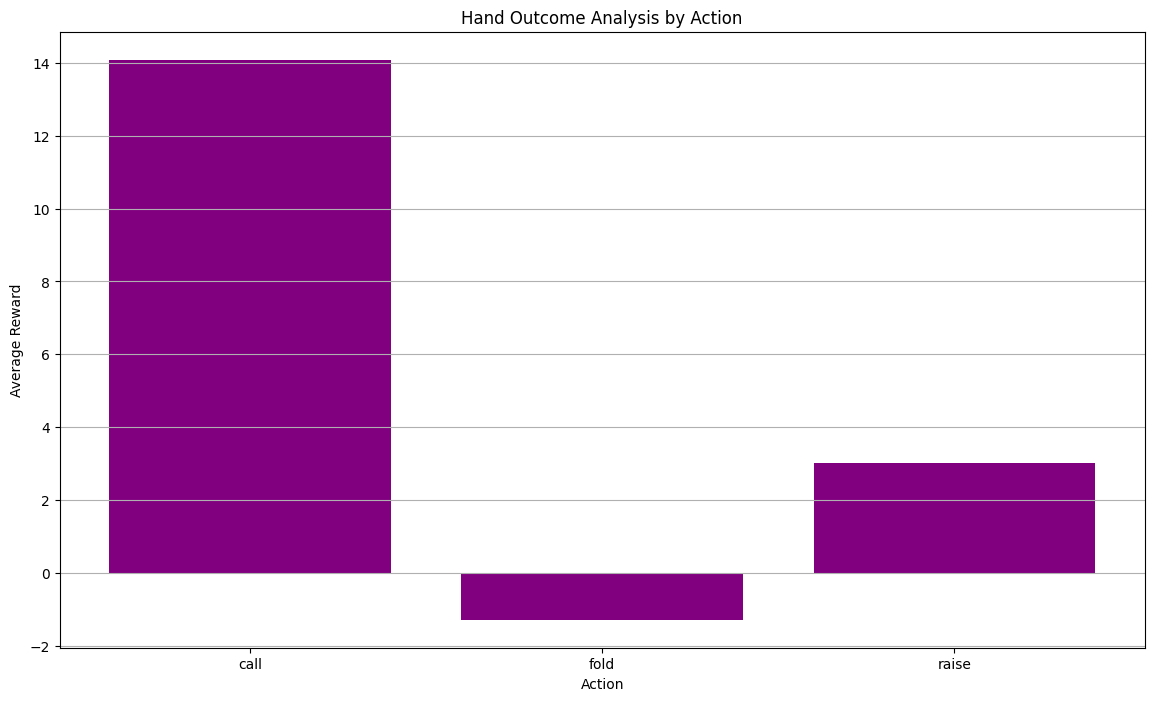

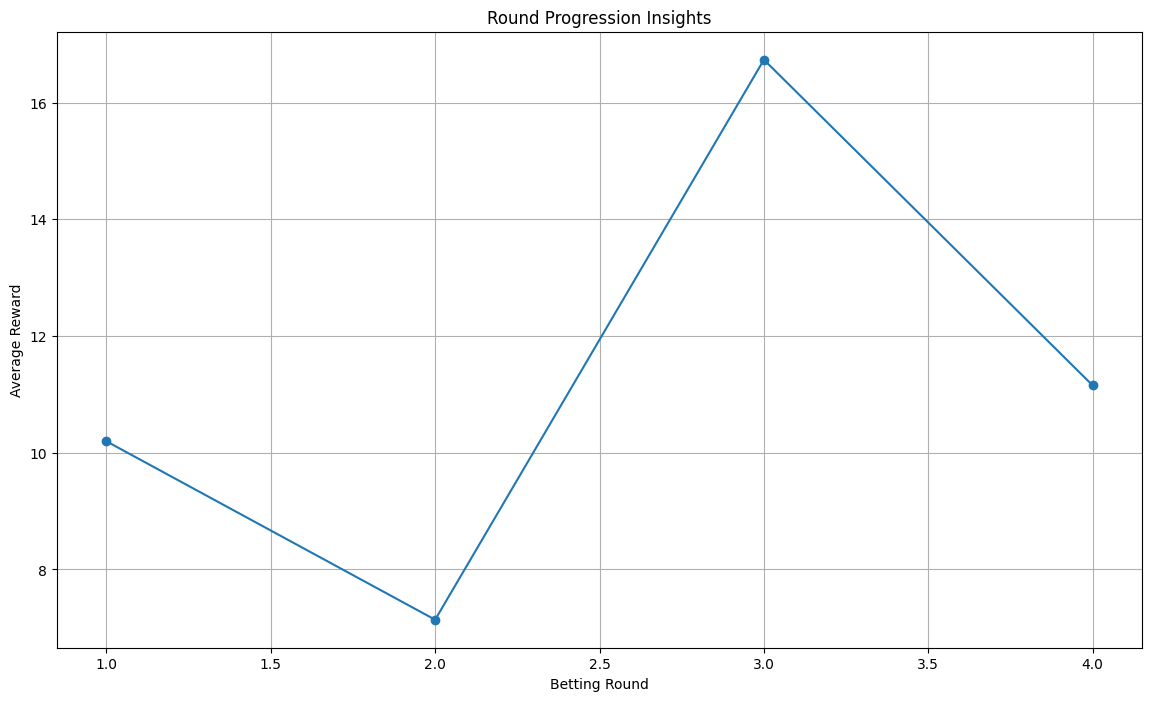

In [ ]:
# Prepare data for analysis
hand_data = []
for log in hand_logs:
    for entry in log:
        hand_data.append({
            'action': entry['action'],
            'agent_hand_strength': environment.evaluate_hand(entry['agent_private_cards'] + entry['community_cards']),
            'opponent_hand_strength': environment.evaluate_hand(entry['opponent_private_cards'] + entry['community_cards']),
            'reward': entry['reward'],
            'betting_round': entry['betting_round']
        })

# Create a DataFrame
df = pd.DataFrame(hand_data)

# Bluffing Efficiency: Hands where the agent bluffed (hand strength <= 3) and won (reward > 0)
df['is_bluff'] = df['agent_hand_strength'] <= 3
df['is_successful_bluff'] = df['is_bluff'] & (df['reward'] > 0)
bluff_summary = pd.DataFrame({
    'Total Bluffs': [df['is_bluff'].sum()],
    'Successful Bluffs': [df['is_successful_bluff'].sum()],
    'Bluff Success Rate (%)': [100 * df['is_successful_bluff'].sum() / df['is_bluff'].sum() if df['is_bluff'].sum() > 0 else 0]
})

# Opponent Exploitation: Group by bluffing frequency level
opponent_stats_df = pd.DataFrame(opponent_stats_over_time)
opponent_stats_df['episode'] = opponent_stats_df.index
df['opponent_bluffing_level'] = pd.cut(
    opponent_stats_df['bluffing_frequency'], bins=[0, 0.3, 0.6, 1], labels=['Low', 'Medium', 'High']
)
exploitation_summary = df.groupby('opponent_bluffing_level')['reward'].mean().reset_index(name='Average Reward')

# Hand Outcome Analysis: Group by action
action_summary = df.groupby('action')['reward'].agg(['mean', 'count']).reset_index()
action_summary.rename(columns={'mean': 'Average Reward', 'count': 'Number of Hands'}, inplace=True)

# Round Progression Insights: Group by betting round
round_summary = df.groupby('betting_round')['reward'].mean().reset_index(name='Average Reward')

# Plot Bluffing Efficiency
plt.figure(figsize=(14, 8))
plt.bar(['Total Bluffs', 'Successful Bluffs'], bluff_summary.iloc[0, :2], color=['blue', 'green'])
plt.title('Bluffing Efficiency')
plt.ylabel('Count')
plt.grid(axis='y')

# Plot Opponent Exploitation
plt.figure(figsize=(14, 8))
plt.bar(exploitation_summary['opponent_bluffing_level'], exploitation_summary['Average Reward'], color='orange')
plt.title('Opponent Exploitation by Bluffing Frequency Level')
plt.ylabel('Average Reward')
plt.xlabel('Opponent Bluffing Level')
plt.grid(axis='y')

# Plot Hand Outcome Analysis
plt.figure(figsize=(14, 8))
plt.bar(action_summary['action'], action_summary['Average Reward'], color='purple')
plt.title('Hand Outcome Analysis by Action')
plt.ylabel('Average Reward')
plt.xlabel('Action')
plt.grid(axis='y')

# Plot Round Progression Insights
plt.figure(figsize=(14, 8))
plt.plot(round_summary['betting_round'], round_summary['Average Reward'], marker='o')
plt.title('Round Progression Insights')
plt.ylabel('Average Reward')
plt.xlabel('Betting Round')
plt.grid()

# Display summaries
import ace_tools as tools; tools.display_dataframe_to_user(name="Bluffing Summary", dataframe=bluff_summary)
tools.display_dataframe_to_user(name="Exploitation Summary", dataframe=exploitation_summary)
tools.display_dataframe_to_user(name="Action Summary", dataframe=action_summary)
tools.display_dataframe_to_user(name="Round Progression Insights", dataframe=round_summary)

plt.show()

In [ ]:
# Filter hands where the betting round is the final round (4)
final_round_hands = [
    hand for episode in hand_logs for hand in episode if hand['betting_round'] == 4
]

final_opponent_actions = [hand['action'] for hand in final_round_hands]
final_agent_actions = [hand['action'] for hand in final_round_hands]
final_rewards = [hand['reward'] for hand in final_round_hands]
final_pot_sizes = [hand.get('pot', 0) for hand in final_round_hands]

final_agent_hand_strengths = [
    environment.calculate_hand_strength(hand['agent_private_cards'], hand['community_cards'])
    for hand in final_round_hands
]

final_opponent_hand_strengths = [
    environment.calculate_hand_strength(hand['opponent_private_cards'], hand['community_cards'])
    for hand in final_round_hands
]

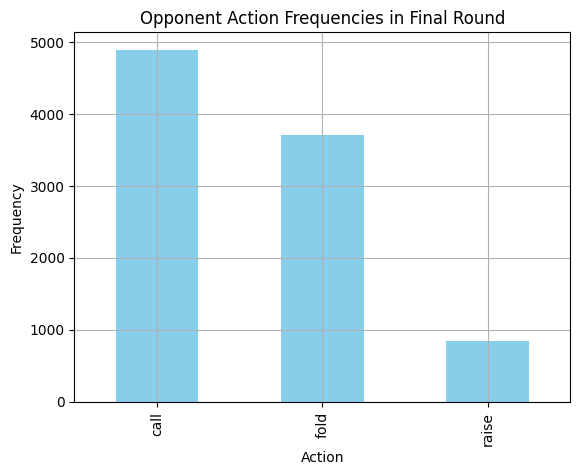

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get all opponent actions in the final betting round
opponent_actions = [hand['action'] for hand in final_round_hands]

# Count frequency of each action
action_counts = pd.Series(opponent_actions).value_counts()

# Plot the frequencies
action_counts.plot(kind='bar', color='skyblue', title="Opponent Action Frequencies in Final Round")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.grid()
plt.show()

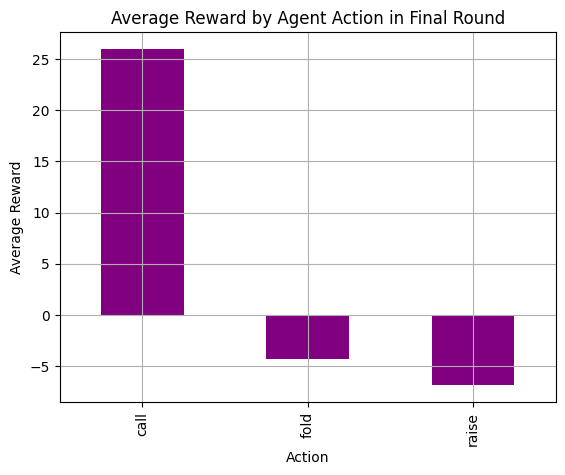

In [ ]:
# Create a DataFrame for actions and rewards
actions_rewards_df = pd.DataFrame({
    'action': final_agent_actions,
    'reward': final_rewards
})

# Group by action and compute mean reward
action_rewards = actions_rewards_df.groupby('action')['reward'].mean()

# Plot the average rewards
action_rewards.plot(kind='bar', color='purple', title="Average Reward by Agent Action in Final Round")
plt.xlabel("Action")
plt.ylabel("Average Reward")
plt.grid()
plt.show()

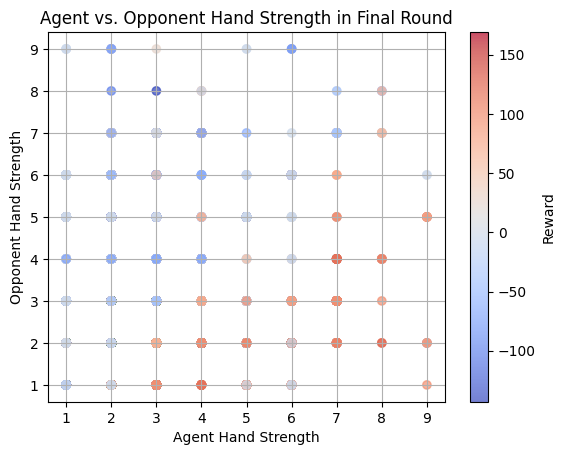

In [ ]:
# Create a DataFrame to compare hand strengths and rewards
hand_strengths_df = pd.DataFrame({
    'agent_strength': final_agent_hand_strengths,
    'opponent_strength': final_opponent_hand_strengths,
    'reward': final_rewards
})

# Plot hand strengths with rewards as color
plt.scatter(hand_strengths_df['agent_strength'], hand_strengths_df['opponent_strength'], c=hand_strengths_df['reward'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Reward")
plt.title("Agent vs. Opponent Hand Strength in Final Round")
plt.xlabel("Agent Hand Strength")
plt.ylabel("Opponent Hand Strength")
plt.grid()
plt.show()

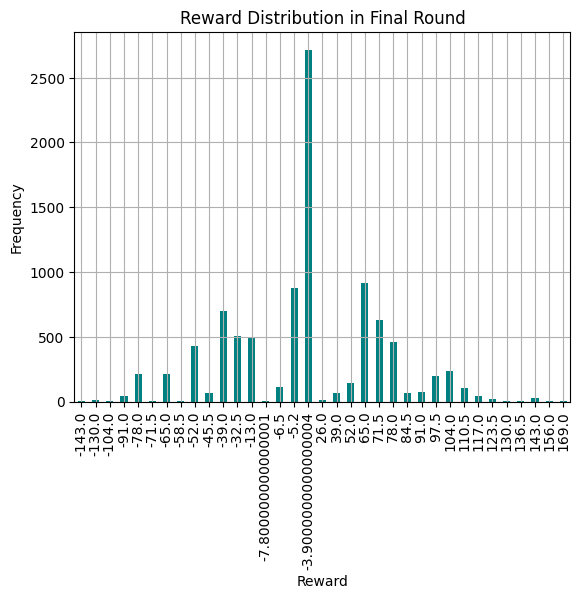

In [ ]:
# Calculate reward distribution
reward_distribution = pd.Series(final_rewards).value_counts().sort_index()

# Plot the distribution
reward_distribution.plot(kind='bar', color='teal', title="Reward Distribution in Final Round")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid()
plt.show()